In [1]:
# Digit Recoginizer

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
import argparse
# find_puzzle
from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border
import numpy as np
import imutils
import cv2

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from sudoku import Sudoku


In [3]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-m", "--model", required=True,help="path to output model after training")
# args = vars(ap.parse_args())

In [2]:
def mnist_data():
    # Download mnist
    print("[INFO] accesssing MNIST... ")
    ((xtrain,ytrain),(xtest,ytest))= mnist.load_data()

    # add channel(i.e Grayscale)
    print("[INFO] adding channel(Grayscale)...")
    xtrain = xtrain.reshape((xtrain.shape[0], 28, 28, 1))
    xtest = xtest.reshape((xtest.shape[0], 28, 28, 1))

    # Scale Data
    print("[INFO] scaling data...")
    xtrain = xtrain.astype('float32')/255.0
    xtest = xtest.astype('float32')/255.0

    # convert labels to vector
    print("[INFO] converting labels to vector...")
    le = LabelBinarizer()
    ytrain = le.fit_transform(ytrain)
    ytest = le.fit_transform(ytest)

    print("[INFO] data is ready!")
    
    return (xtrain,ytrain,xtest,ytest)

In [55]:
# ANN Model

class SudokuNet:
    # hyperparameters init_learning rate, epoch, batch size
    INIT_LR = 1e-3
    EPOCHS = 10
    BS = 128
    
    @staticmethod
    
    def build(height,width,depth,classes):
        inputShape=( height, width, depth)
        model=Sequential()
        
        # first set of Conv-> ReLu-> Pooling Layers
        model.add(Conv2D(32, (5,5), padding='same', input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2)))

        #  second set of Conv-> ReLu-> Pooling Layers
        model.add(Conv2D(32, (3,3), padding='same'))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2)))

        #  first Dense Layer
        model.add(Flatten())
        model.add(Dense(64))
        model.add(Activation("relu"))
        model.add(Dropout(0.5))

        #  second set of dense layer
        model.add(Dense(64))
        model.add(Activation("relu"))
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        return model
    
    def mnist_data():
        # Download mnist
        print("[INFO] accesssing MNIST... ")
        ((xtrain,ytrain),(xtest,ytest))= mnist.load_data()

        # add channel(i.e Grayscale)
        print("[INFO] adding channel(Grayscale)...")
        xtrain = xtrain.reshape((xtrain.shape[0], 28, 28, 1))
        xtest = xtest.reshape((xtest.shape[0], 28, 28, 1))

        # Scale Data
        print("[INFO] scaling data...")
        xtrain = xtrain.astype('float32')/255.0
        xtest = xtest.astype('float32')/255.0

        # convert labels to vector
        print("[INFO] converting labels to vector...")
        le = LabelBinarizer()
        ytrain = le.fit_transform(ytrain)
        ytest = le.fit_transform(ytest)

        print("[INFO] data is ready!")

        return (xtrain,ytrain,xtest,ytest,le)

    def NN_model():
        # initialize optimizer and model
        print("[INFO] compiling model...")
        opt=Adam(lr=SudokuNet.INIT_LR)
        model=SudokuNet.build(height=28,width=28,depth=1,classes=10)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        (xtrain,ytrain,xtest,ytest,le) = SudokuNet.mnist_data()
        #  train the network
        print("[INFO] training network...")
        H=model.fit(
            xtrain,ytrain,
            validation_data=(xtest,ytest),
            batch_size=SudokuNet.BS,
            epochs=SudokuNet.EPOCHS,
            verbose=1)
        print("[INFO] evaluating model...")
        predictions=model.predict(xtest)
        print(classification_report(
                                    ytest.argmax(axis=1),
                                    predictions.argmax(axis=1),
                                    target_names=[str(x) for x in le.classes_]))

        # serialize the model to disk
        print("[INFO] serialize digit model...")
        model.save("digit_model.h5",save_format="h5")
        
        print("[INFO] task NN_model completed!")
        return model
    
    def find_puzzle(image,debug=False):
        # convert image to grayscale and blur it slightly
        gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (9, 9), 1)
        thresh = cv2.adaptiveThreshold(blurred, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        thresh = cv2.bitwise_not(thresh)
#         kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]])
#         thresh = cv2.dilate(thresh, kernel)
        # for debugging
        if debug:
            cv2.imshow('Puzzle Thresh', thresh)
            cv2.waitKey(0)
        # find contours in threshold image and sort in descending order
        cnts=cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        cnts=imutils.grab_contours(cnts)
        cnts=sorted(cnts,key=cv2.contourArea,reverse=True)
        # initalize a contour
        puzzlecnt=None

        for c in cnts:
            # approximate the contour
            peri=cv2.arcLength(c,True)
            approx=cv2.approxPolyDP(c,0.02*peri,True)
            # if approx contour has 4 pts , then assume it as puzzle
            if (len(approx)==4):
                puzzlecnt=approx
                break
        # if puzzle contour is empty, raise an error
        if puzzlecnt is None:
            raise Exception(("Could not find sudoku puzzle outline."
                            "Try debugging your thresholding and contour steps."))
        # check to see if we are visualizing the outline of detected sudoku
        if debug:
            output=image.copy()
            cv2.drawContours(output,[puzzlecnt],-1,(0,255,0),2)
            cv2.imshow("Puzzle Outline", output)
            cv2.waitKey(0)
        # apply a 4 point perspective transform to both images
        puzzle=four_point_transform(image,puzzlecnt.reshape(4,2))
        warped=four_point_transform(gray,puzzlecnt.reshape(4,2))
        blurred = cv2.GaussianBlur(puzzle, (9, 9), 1)
        
        # check to visualize perspective transform
        if debug:
            cv2.imshow("Puzzle Transform", puzzle)
            cv2.waitKey(0)
        cv2.destroyAllWindows()
        return (puzzle,warped)
    
    def extract_digit(cell,debug=False):
        # apply thresholding to the cell and then clear
        # any connected borders that touch the border of cell
        
        thresh = cv2.adaptiveThreshold(cell, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        thresh = cv2.bitwise_not(thresh)
#         thresh = cv2.threshold(cell,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = clear_border(thresh)
        # check to visualize cell thresholding
        if debug:
            cv2.imshow("Cell Thresh",thresh)
            cv2.waitKey(0)
        #  find contours in threshold cells
        cnts=cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        cnts=imutils.grab_contours(cnts)

        # if no  contour were found this is empty cell
        if len(cnts)==0:
            return None
        # otherwise,find largest contours in threshold cells
        c=max(cnts,key=cv2.contourArea)
        mask=np.zeros(thresh.shape,dtype="uint8")
        cv2.drawContours(mask,[c],-1,255,-1)

        # compute the percentage of masked pixels
        # relative to the total area of image

        (h,w)=thresh.shape
        percentFilled = cv2.countNonZero(mask)/float(w*h)

        # if percent is < 3% of the mask, we r looking at noise
        # and can safely ignore contour
        if percentFilled<0.03:
            return None
        # apply mask to threshold cell
        digit=cv2.bitwise_and(thresh,thresh,mask=mask)
        # check to visualize masking step
        if debug:
            cv2.imshow("Digit",digit)
            cv2.waitKey(0)
        cv2.destroyAllWindows()
        return digit
    
    

In [ ]:
# SudokuSolver
from tensorflow.keras.preprocessing.image import img_to_array
# from tensorflow.keras.models import load_model
# # Load the digit classsifier
# print("[INFO] processing image...")
# model=load_model('digit_model.h5')

# load input image
print("[INFO] processing image...")
image=cv2.imread(path)
# image=imutils.resize(image,width=600)

# find the puzzle in image
(puzzleImage,warped)=SudokuNet.find_puzzle(image)

# initialize 9X9 sudoku board
board=np.zeros((9,9),dtype="int")

# calculating each cell
stepX = warped.shape[1] // 9
stepY = warped.shape[0] // 9

#  init a list to store (x,y) co-ordinate of each cell
cellLocs=[]
# Loop over grid locations
for y in range(0,9):
    row=[]
    for x in range(0,9):
        startX=x*stepX
        startY=y*stepY
        endX= (x+1)*stepX
        endY= (y+1)*stepY
        row.append((startX,startY,endX,endY))
        
        cell=warped[startY:endY, startX:endX]
#         plt.imshow(cell, cmap='gray')
        digit=SudokuNet.extract_digit(cell)
#         print(digit)
#         cv2.waitKey(0)
#         plt.imshow(digit, cmap='gray')
#         plt.imshow(digit)
        if digit is not None:
            # resize to 28X28
            roi=cv2.resize(digit,(28,28))
            roi=roi.astype("float32")/255.0
            roi=img_to_array(roi)
            roi=np.expand_dims(roi,axis=0)
            # classify the digit
            pred=model.predict(roi).argmax(axis=1)[0]
            board[y,x]=pred
            
            cv2.putText(cell,  
                str(pred),  
                (50, 50),  
                cv2.FONT_HERSHEY_SIMPLEX , 1,  
                (0, 255, 255),  
                2,  
                cv2.LINE_4) 
            cv2.imshow("pred",digit)
            cv2.waitKey(0)
        
   
    # add the row
    cv2.destroyAllWindows()
    cellLocs.append(row)
            



[INFO] processing image...


In [111]:
 cv2.destroyAllWindows()

In [100]:
board

array([[0, 5, 5, 1, 0, 0, 0, 0, 0],
       [2, 0, 8, 0, 6, 0, 0, 0, 2],
       [1, 0, 0, 5, 6, 0, 7, 0, 0],
       [6, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 5, 0, 0, 0],
       [3, 0, 6, 0, 0, 0, 0, 4, 9],
       [0, 0, 0, 0, 1, 0, 0, 3, 0],
       [0, 4, 0, 3, 0, 0, 0, 0, 8],
       [7, 0, 0, 0, 0, 0, 4, 0, 0]])

In [91]:
thresh = cv2.threshold(cell,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
thresh = clear_border(thresh)
# check to visualize cell thresholding
# if debug:
#     cv2.imshow("Cell Thresh",thresh)
#     cv2.waitKey(0)
#  find contours in threshold cells
cnts=cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts=imutils.grab_contours(cnts)

# if no  contour were found this is empty cell
if len(cnts)==0:
    pass
# otherwise,find largest contours in threshold cells
c=max(cnts,key=cv2.contourArea)
mask=np.zeros(thresh.shape,dtype="uint8")
cv2.drawContours(mask,[c],-1,255,-1)

# compute the percentage of masked pixels
# relative to the total area of image

(h,w)=thresh.shape
percentFilled = cv2.countNonZero(mask)/float(w*h)

# if percent is < 3% of the mask, we r looking at noise
# and can safely ignore contour
if percentFilled<0.03:
    pass
# apply mask to threshold cell
digit=cv2.bitwise_and(thresh,thresh,mask=mask)
# check to visualize masking step
# if debug:
#     cv2.imshow("Digit",digit)
#     cv2.waitKey(0)
# cv2.destroyAllWindows()

ValueError: max() arg is an empty sequence

In [82]:
cnts[0].shape

(131, 1, 2)

In [14]:
# initialize optimizer and model
print("[INFO] compiling model...")
opt=Adam(lr=INIT_LR)
model=SudokuNet.build(height=28,width=28,depth=1,classes=10)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

#  train the network
print("[INFO] training network...")
H=model.fit(
    xtrain,ytrain,
    validation_data=(xtest,ytest),
    batch_size=BS,
    epochs=EPOCHS,
    verbose=1)

[INFO] compiling model...
(28, 28, 1)
[INFO] training network...
Epoch 1/10
469/469 [==============================] - 48s 102ms/step - loss: 0.7027 - accuracy: 0.7674 - val_loss: 0.0888 - val_accuracy: 0.9761
Epoch 2/10
469/469 [==============================] - 47s 101ms/step - loss: 0.2621 - accuracy: 0.9222 - val_loss: 0.0581 - val_accuracy: 0.9836
Epoch 3/10
469/469 [==============================] - 47s 101ms/step - loss: 0.1880 - accuracy: 0.9449 - val_loss: 0.0459 - val_accuracy: 0.9858
Epoch 4/10
469/469 [==============================] - 47s 101ms/step - loss: 0.1628 - accuracy: 0.9519 - val_loss: 0.0434 - val_accuracy: 0.9873
Epoch 5/10
469/469 [==============================] - 48s 101ms/step - loss: 0.1471 - accuracy: 0.9576 - val_loss: 0.0416 - val_accuracy: 0.9880
Epoch 6/10
469/469 [==============================] - 72s 153ms/step - loss: 0.1361 - accuracy: 0.9606 - val_loss: 0.0374 - val_accuracy: 0.9878
Epoch 7/10
469/469 [==============================] - 50s 107ms/s

In [20]:
# Evaluate the model
print("[INFO] evaluating model...")
predictions=model.predict(xtest)
print(classification_report(
                            ytest.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[str(x) for x in le.classes_]))

# serialize the model to disk
print("[INFO] serialize digit model...")
model.save("digit_model.h5",save_format="h5")


[INFO] evaluating model...
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.98      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

[INFO] serialize digit model...


# Next

find_puzzle: Locates and extracts the sudoku puzzle board from the input image
             
extract_digit: Examines each cell of the sudoku puzzle board and extracts the digit from the cell (provided there                is a digit)


In [4]:
# find_puzzle
from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border
import numpy as np
import imutils
import cv2

In [5]:
def find_puzzle(image,debug=False):
    # convert image to grayscale and blur it slightly
    gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7, 7), 3)
    thresh = cv2.adaptiveThreshold(blurred, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    thresh = cv2.bitwise_not(thresh)
    # for debugging
    if debug:
        cv2.imshow('Puzzle Thresh', thresh)
        cv2.waitKey(0)
    # find contours in threshold image and sort in descending order
    cnts=cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts=imutils.grab_contours(cnts)
    cnts=sorted(cnts,key=cv2.contourArea,reverse=True)
    # initalize a contour
    puzzlecnt=None
    
    for c in cnts:
        # approximate the contour
        peri=cv2.arcLength(c,True)
        approx=cv2.approxPolyDP(c,0.02*peri,True)
        # if approx contour has 4 pts , then assume it as puzzle
        if (len(approx)==4):
            puzzlecnt=approx
            break
    # if puzzle contour is empty, raise an error
    if puzzlecnt is None:
        raise Exception(("Could not find sudoku puzzle outline."
                        "Try debugging your thresholding and contour steps."))
    # check to see if we are visualizing the outline of detected sudoku
    if debug:
        output=image.copy()
        cv2.drawContours(output,[puzzlecnt],-1,(0,255,0),2)
        cv2.imshow("Puzzle Outline", output)
        cv2.waitKey(0)
    # apply a 4 point perspective transform to both images
    puzzle=four_point_transform(image,puzzlecnt.reshape(4,2))
    warped=four_point_transform(gray,puzzlecnt.reshape(4,2))
    
    # check to visualize perspective transform
    if debug:
        cv2.imshow("Puzzle Transform", puzzle)
        cv2.waitKey(0)
    cv2.destroyAllWindows()
    return (puzzle,warped)

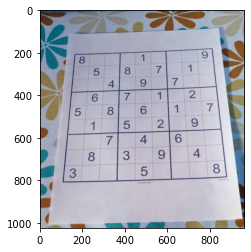

In [9]:
path='/home/raghav/Desktop/sudoku_puzzle.jpg'
import matplotlib.pyplot as plt
image=cv2.imread(path)
# debug=True
# cv2.namedWindow( "Display window", cv2.WINDOW_AUTOSIZE );
#percent by which the image is resized
scale_percent = 50
src=image
#calculate the 50 percent of original dimensions
width = int(src.shape[1] * scale_percent / 100)
height = int(src.shape[0] * scale_percent / 100)

# dsize
dsize = (width, height)

# resize image
output = cv2.resize(src, dsize)
cv2.imshow("Thresh", output)
cv2.waitKey(0)
plt.imshow(image)

In [13]:
find_puzzle(image,True)

(array([[[107, 105, 141],
         [103, 102, 140],
         [104, 105, 142],
         ...,
         [114, 103, 143],
         [129, 119, 151],
         [161, 156, 183]],
 
        [[ 68,  67, 107],
         [ 62,  62, 104],
         [ 67,  68, 111],
         ...,
         [105,  92, 135],
         [120, 106, 140],
         [152, 144, 172]],
 
        [[ 60,  57, 102],
         [ 57,  54,  96],
         [ 56,  55,  94],
         ...,
         [105,  88, 130],
         [122, 103, 140],
         [152, 141, 170]],
 
        ...,
 
        [[ 76,  68, 110],
         [ 68,  56, 103],
         [ 66,  53,  98],
         ...,
         [ 97,  90, 131],
         [105,  90, 132],
         [119,  93, 131]],
 
        [[ 99,  93, 131],
         [ 68,  58, 102],
         [ 59,  47,  93],
         ...,
         [111,  93, 135],
         [112,  92, 129],
         [122, 102, 133]],
 
        [[132, 130, 160],
         [ 98,  92, 127],
         [ 80,  72, 109],
         ...,
         [154, 139, 169],
  

In [ ]:
# convert image to grayscale and blur it slightly
gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (7, 7), 3)
thresh = cv2.adaptiveThreshold(blurred, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
thresh = cv2.bitwise_not(thresh)
# for debugging
cv2.imshow("Thresh", image)
cv2.waitKey(0)

In [18]:
cv2.destroyAllWindows()

In [71]:
thresh = cv2.adaptiveThreshold(blurred, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

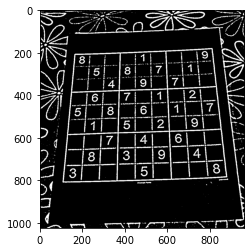

In [77]:
plt.imshow(thresh,cmap='gray')

In [ ]:
image=cv2.imread(path)
puzzle,warp=find_puzzle(image)  
plt.imshow(puzzle)

In [6]:
# extract digit
def extract_digit(cell,debug=False):
    # apply thresholding to the cell and then clear
    # any connected borders that touch the border of cell
    thresh = cv2.threshold(cell,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    thresh = clear_border(thresh)
    # check to visualize cell thresholding
    if debug:
        cv2.imshow("Cell Thresh",thresh)
        cv2.waitKey(0)
    #  find contours in threshold cells
    cnts=cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts=imutils.grab_contours(cnts)
    
    # if no  contour were found this is empty cell
    if len(cnts)==0:
        return None
    # otherwise,find largest contours in threshold cells
    c=max(cnts,key=cv2.contourArea)
    mask=np.zeros(thresh.shape,dtype="uint8")
    cv2.drawContours(mask,[c],-1,255,-1)
    
    # compute the percentage of masked pixels
    # relative to the total area of image
    
    (h,w)=thresh.shape
    percentFilled = cv2.countNonZero(mask)/float(w*h)
    
    # if percent is < 3% of the mask, we r looking at noise
    # and can safely ignore contour
    if percentFilled<0.03:
        return None
    # apply mask to threshold cell
    digit=cv2.bitwise_and(thresh,thresh,mask=mask)
    # check to visualize masking step
    if debug:
        cv2.imshow("Digit",digit)
        cv2.waitKey(0)
    cv2.destroyAllWindows()
    return digit

In [11]:
path='/home/raghav/Downloads/su1.jpg'
# path='/home/raghav/Desktop/sudoku_puzzle.jpg'

In [3]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
# Load the digit classsifier
print("[INFO] processing image...")
model=load_model('adam-99.h5')

[INFO] processing image...


In [12]:
# SudokuSolver
from tensorflow.keras.preprocessing.image import img_to_array
# from tensorflow.keras.models import load_model
# # Load the digit classsifier
# print("[INFO] processing image...")
# model=load_model('digit_model.h5')

# load input image
print("[INFO] processing image...")
image=cv2.imread(path)
# image=imutils.resize(image,width=600)

# find the puzzle in image
(puzzleImage,warped)=SudokuNet.find_puzzle(image,True)

# # initialize 9X9 sudoku board
# board=np.zeros((9,9),dtype="int")

# # calculating each cell
# stepX = warped.shape[1] // 9
# stepY = warped.shape[0] // 9

# #  init a list to store (x,y) co-ordinate of each cell
# cellLocs=[]
# # Loop over grid locations
# for y in range(0,9):
#     row=[]
#     for x in range(0,9):
#         startX=x*stepX
#         startY=y*stepY
#         endX= (x+1)*stepX
#         endY= (y+1)*stepY
#         row.append((startX,startY,endX,endY))
        
#         cell=warped[startY:endY, startX:endX]
#         digit=extract_digit(cell,True)
#         if digit is not None:
#             # resize to 28X28
#             roi=cv2.resize(digit,(28,28))
#             roi=roi.astype("float")/255.0
#             roi=img_to_array(roi)
#             roi=np.expand_dims(roi,axis=0)
#             # classify the digit
#             pred=model.predict(roi).argmax(axis=1)[0]
#             board[y,x]=pred
#     # add the row
#     cellLocs.append(row)
            



[INFO] processing image...


In [11]:
board

array([[8, 0, 0, 0, 1, 0, 0, 0, 9],
       [0, 5, 0, 8, 0, 7, 0, 1, 0],
       [0, 0, 4, 0, 9, 0, 7, 0, 0],
       [0, 8, 0, 7, 0, 1, 0, 2, 0],
       [5, 0, 8, 0, 8, 0, 1, 0, 7],
       [0, 1, 0, 5, 0, 2, 0, 9, 0],
       [0, 0, 7, 0, 4, 0, 8, 0, 0],
       [0, 8, 0, 3, 0, 9, 0, 4, 0],
       [3, 0, 0, 0, 5, 0, 0, 0, 8]])

In [12]:
from sudoku import Sudoku
# construct a sudoku puzzle from the board
print("[INFO] OCR'd sudoku board:")
puzzle = Sudoku(3, 3, board=board.tolist())
puzzle.show()
# solve the sudoku puzzle
print("[INFO] solving sudoku puzzle...")
solution = puzzle.solve()
solution.show_full()

[INFO] OCR'd sudoku board:
+-------+-------+-------+
| 8     |   1   |     9 |
|   5   | 8   7 |   1   |
|     4 |   9   | 7     |
+-------+-------+-------+
|   8   | 7   1 |   2   |
| 5   8 |   8   | 1   7 |
|   1   | 5   2 |   9   |
+-------+-------+-------+
|     7 |   4   | 8     |
|   8   | 3   9 |   4   |
| 3     |   5   |     8 |
+-------+-------+-------+

[INFO] solving sudoku puzzle...

---------------------------
9x9 (3x3) SUDOKU PUZZLE
Difficulty: INVALID PUZZLE (GIVEN PUZZLE HAS NO SOLUTION)
---------------------------
+-------+-------+-------+
|       |       |       |
|       |       |       |
|       |       |       |
+-------+-------+-------+
|       |       |       |
|       |       |       |
|       |       |       |
+-------+-------+-------+
|       |       |       |
|       |       |       |
|       |       |       |
+-------+-------+-------+

        


In [ ]:
# loop over the cell locations and board
for (cellRow, boardRow) in zip(cellLocs, solution.board):
    # loop over individual cell in the row
    for (box, digit) in zip(cellRow, boardRow):
        # unpack the cell coordinates
        startX, startY, endX, endY = box
        # compute the coordinates of where the digit will be drawn
        # on the output puzzle image
        textX = int((endX - startX) * 0.33)
        textY = int((endY - startY) * -0.2)
        textX += startX
        textY += endY
        # draw the result digit on the sudoku puzzle image
        cv2.putText(puzzleImage, str(digit), (textX, textY),
            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 25), 2)
# show the output image
cv2.imshow("Sudoku Result", puzzleImage)
cv2.waitKey(0)

In [8]:
# Infference
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from sudoku import Sudoku
# Load the digit classsifier
print("[INFO] processing image...")
model=load_model('digit_model.h5')


[INFO] processing image...


In [25]:
SudokuNet.NN_model()

[INFO] compiling model...
[INFO] accesssing MNIST... 
[INFO] adding channel(Grayscale)...
[INFO] scaling data...
[INFO] converting labels to vector...
[INFO] data is ready!
[INFO] training network...
Epoch 1/10
469/469 [==============================] - 47s 101ms/step - loss: 0.7105 - accuracy: 0.7664 - val_loss: 0.0917 - val_accuracy: 0.9713
Epoch 2/10
469/469 [==============================] - 48s 102ms/step - loss: 0.2557 - accuracy: 0.9262 - val_loss: 0.0668 - val_accuracy: 0.9809
Epoch 3/10
469/469 [==============================] - 48s 101ms/step - loss: 0.1880 - accuracy: 0.9452 - val_loss: 0.0508 - val_accuracy: 0.9854
Epoch 4/10
469/469 [==============================] - 48s 102ms/step - loss: 0.1592 - accuracy: 0.9545 - val_loss: 0.0476 - val_accuracy: 0.9867
Epoch 5/10
469/469 [==============================] - 48s 103ms/step - loss: 0.1360 - accuracy: 0.9616 - val_loss: 0.0374 - val_accuracy: 0.9882
Epoch 6/10
469/469 [==============================] - 48s 103ms/step - loss

In [9]:
path='/home/raghav/Desktop/sudoku_puzzle.jpg'

In [ ]:
# Load the digit classsifier
print("[INFO] processing image...")
model=load_model('digit_model.h5')

image=cv2.imread(path)
image=imutils.resize(image,width=600)
cv2.imshow("Input Given",image)
cv2.waitKey(0)
(puzzleImage,warped)=SudokuNet.find_puzzle(image)

# initialize 9X9 sudoku board
board=np.zeros((9,9),dtype="int")

# calculating each cell
stepX = warped.shape[1] // 9
stepY = warped.shape[0] // 9

# init a list to store (x,y) co-ordinate of each cell
cellLocs=[]
# Loop over grid locations
for y in range(0,9):
    row=[]
    for x in range(0,9):
        startX=x*stepX
        startY=y*stepY
        endX= (x+1)*stepX
        endY= (y+1)*stepY
        row.append((startX,startY,endX,endY))
        cell=warped[startY:endY, startX:endX]
        digit=SudokuNet.extract_digit(cell)
        if digit is not None:
            # resize to 28X28
            roi=cv2.resize(digit,(28,28))
            roi=roi.astype("float")/255.0
            roi=img_to_array(roi)
            roi=np.expand_dims(roi,axis=0)
            # classify the digit
            pred=model.predict(roi).argmax(axis=1)[0]
            board[y,x]=pred
        # add the row
        cellLocs.append(row)

# construct a sudoku puzzle from the board
# print("[INFO] OCR'd sudoku board:")
puzzle = Sudoku(3, 3, board=board.tolist())
#     puzzle.show()
# solve the sudoku puzzle
#     print("[INFO] solving sudoku puzzle...")
solution = puzzle.solve()
#         solution.show_full()
for (cellRow, boardRow) in zip(cellLocs, solution.board):
    # loop over individual cell in the row
    for (box, digit) in zip(cellRow, boardRow):
        # unpack the cell coordinates
        startX, startY, endX, endY = box
        # compute the coordinates of where the digit will be drawn
        # on the output puzzle image
        textX = int((endX - startX) * 0.33)
        textY = int((endY - startY) * -0.2)
        textX += startX
        textY += endY
        # draw the result digit on the sudoku puzzle image
        cv2.putText(puzzleImage, str(digit), (textX, textY),
        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 25), 2)
        # show the output image
cv2.imshow("Sudoku Result", puzzleImage)
cv2.waitKey(0)

[INFO] processing image...


In [ ]:
# define a video capture object 
# vid = cv2.VideoCapture(0) 
  
while(True): 
      
    # Capture the video frame 
    # by frame 
#     ret, frame = vid.read() 
  
    # Display the resulting frame 
#     cv2.imshow('frame', frame) 
    

    # load input image
#     print("[INFO] processing image...")
    image=cv2.imread(path)
    image=imutils.resize(image,width=600)
    cv2.imshow("Input Given",image)
    cv2.waitKey(0)
#     if cv2.waitKey(1) & 0xFF == ord('c'): 
    if True:   
#         cv2.imshow("capture",image)
        # find the puzzle in image
        (puzzleImage,warped)=find_puzzle(image)

        # initialize 9X9 sudoku board
        board=np.zeros((9,9),dtype="int")

        # calculating each cell
        stepX = warped.shape[1] // 9
        stepY = warped.shape[0] // 9

        #  init a list to store (x,y) co-ordinate of each cell
        cellLocs=[]
        # Loop over grid locations
        for y in range(0,9):
            row=[]
            for x in range(0,9):
                startX=x*stepX
                startY=y*stepY
                endX= (x+1)*stepX
                endY= (y+1)*stepY
                row.append((startX,startY,endX,endY))

                cell=warped[startY:endY, startX:endX]
                digit=extract_digit(cell)
                if digit is not None:
                    # resize to 28X28
                    roi=cv2.resize(digit,(28,28))
                    roi=roi.astype("float")/255.0
                    roi=img_to_array(roi)
                    roi=np.expand_dims(roi,axis=0)
                    # classify the digit
                    pred=model.predict(roi).argmax(axis=1)[0]
                    board[y,x]=pred
            # add the row
            cellLocs.append(row)

        # construct a sudoku puzzle from the board
    #     print("[INFO] OCR'd sudoku board:")
        puzzle = Sudoku(3, 3, board=board.tolist())
    #     puzzle.show()
        # solve the sudoku puzzle
    #     print("[INFO] solving sudoku puzzle...")
        solution = puzzle.solve()
#         solution.show_full()

        for (cellRow, boardRow) in zip(cellLocs, solution.board):
            # loop over individual cell in the row
            for (box, digit) in zip(cellRow, boardRow):
                # unpack the cell coordinates
                startX, startY, endX, endY = box
                # compute the coordinates of where the digit will be drawn
                # on the output puzzle image
                textX = int((endX - startX) * 0.33)
                textY = int((endY - startY) * -0.2)
                textX += startX
                textY += endY
                # draw the result digit on the sudoku puzzle image
                cv2.putText(puzzleImage, str(digit), (textX, textY),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 25), 2)
        # show the output image
        cv2.imshow("Sudoku Result", puzzleImage)
        cv2.waitKey(0)
    
    # the 'q' button is set as the 
    # quitting button you may use any 
    # desired button of your choice 
    break
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break
  
# After the loop release the cap object 
# vid.release() 
# Destroy all the windows 
cv2.destroyAllWindows() 

In [20]:
cv2.destroyAllWindows() 
# vid.release() 